# Test Neurolearn Functionality

In [1]:
from pyneurovault import api
import os
import pandas as pd
import matplotlib.pyplot as plt
import time
import nibabel as nb
import numpy as np
import pickle
from nltools.analysis import Predict, apply_mask, Roc
%matplotlib inline

from nltools.stats import auc
from scipy.stats import norm, binom_test
from nltools.plotting import roc_plot
outfolder = "/Users/lukechang/Downloads/nv_tmp"


Couldn't import dot_parser, loading of dot files will not be possible.


# Download Pain Images

In [13]:
tic = time.time() #Start Timer

# Pain Collection
collection = 504

# Will extract all collections and images in one query to work from
nv = api.NeuroVault()

# Download all images to file
standard = os.path.join(os.path.dirname(api.__file__),'data','MNI152_T1_2mm_brain.nii.gz')
nv.download_images(dest_dir = outfolder,target=standard, collection_ids=[collection],resample=False)

# Create Variables
collection_data = nv.get_images_df().ix[nv.get_images_df().collection_id == collection,:].reset_index()
img_index = sorted((e,i) for i,e in enumerate(collection_data.file))
index = [x[1] for x in img_index]
img_file = [x[0] for x in img_index]

dat = nb.funcs.concat_images([os.path.join(outfolder,'original',str(x) + '.nii.gz') for x in collection_data.image_id[index]])
holdout = [int(x.split('_')[-2]) for x in img_file]
heat_level = [x.split('_')[-1].split('.')[0] for x in img_file]
Y_dict = {'High':3,'Medium':2,'Low':1}
Y = np.array([Y_dict[x] for x in heat_level])

# Pickle for later use
# Saving the objects:
with open(os.path.join(outfolder,'Pain_Data.pkl'), 'w') as f:
    pickle.dump([dat,holdout,Y], f)

print 'Elapsed: %.2f seconds' % (time.time() - tic) #Stop timer

Extracting NeuroVault collections meta data...
Found 238 results.
Extracting NeuroVault images meta data...
Found 6302 results.
Retrieving http://neurovault.org/api/images/?format=json&limit=1000&offset=1000
Retrieving http://neurovault.org/api/images/?format=json&limit=1000&offset=2000
Retrieving http://neurovault.org/api/images/?format=json&limit=1000&offset=3000
Retrieving http://neurovault.org/api/images/?format=json&limit=1000&offset=4000
Retrieving http://neurovault.org/api/images/?format=json&limit=1000&offset=5000
Retrieving http://neurovault.org/api/images/?format=json&limit=1000&offset=6000
NeuroVault Object (nv) Includes <nv.images><nv.collections>
Elapsed: 172.62 seconds


# Load Pickled Data

In [2]:
tic = time.time() #Start Timer

# Getting back the objects:
with open(os.path.join(outfolder,'Pain_Data.pkl')) as f:
    dat, holdout, Y = pickle.load(f)
print 'Load Pickled File - Elapsed: %.2f seconds' % (time.time() - tic) #Stop timer


Load Pickled File - Elapsed: 9.38 seconds


# Run Prediction

overall Root Mean Squared Error: 0.98
overall Correlation: 0.55
Total Elapsed: 4.15 seconds


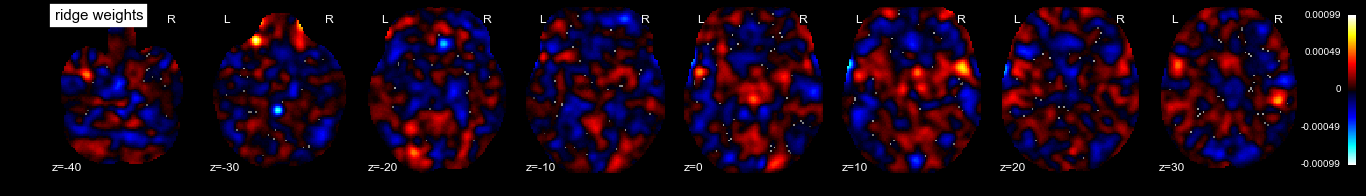

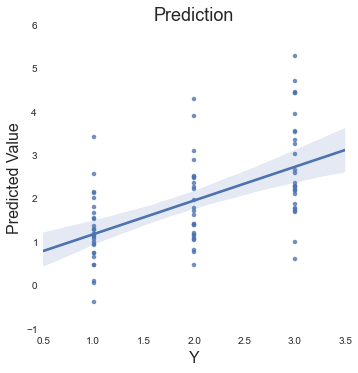

In [3]:
tic = time.time() #Start Timer

## Test Prediction with kfold xVal
# SVR
# negvneu = Predict(dat,Y,algorithm='svr',subject_id = holdout, output_dir=outfolder, cv_dict = {'kfolds':5}, **{'kernel':"linear"})
# negvneu = Predict(dat,Y,algorithm='svr',subject_id = holdout, output_dir=outfolder, cv_dict = {'loso':holdout}, **{'kernel':"linear"})
# negvneu.predict()
# print 'Elapsed: %.2f seconds' % (time.time() - tic) #Stop timer

# Ridge
negvneu = Predict(dat,Y,algorithm='ridge',subject_id = holdout, output_dir=outfolder, cv_dict = {'kfolds':5})
negvneu.predict()

# # Principal Components Regression
# negvneu = Predict(dat,Y,algorithm='pcr',subject_id = holdout, output_dir=outfolder, cv_dict = {'kfolds':5})
# negvneu.predict()
print 'Total Elapsed: %.2f seconds' % (time.time() - tic) #Stop timer


In [22]:
# Find similarity bewteen two patterns - use apply_mask

from nilearn.input_data import NiftiMasker
mask = nb.load('/Users/lukechang/Github/neurolearn/nltools/resources/MNI152_T1_2mm_brain_mask_dil.nii.gz')
nifti_masker = NiftiMasker(mask_img=mask)
pcr = nb.load(os.path.join(outfolder,'pcr_weightmap.nii.gz'))
ridge = nb.load(os.path.join(outfolder,'ridge_weightmap.nii.gz'))
pcr_mask = nifti_masker.fit_transform(pcr)
ridge_mask = nifti_masker.fit_transform(ridge)
np.corrcoef(pcr_mask,ridge_mask)

array([[ 1.        ,  0.99999993],
       [ 0.99999993,  1.        ]])

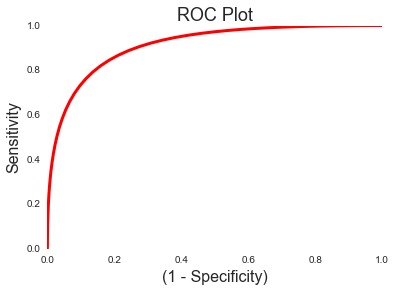

In [6]:
# Test ROC Plot
negvneu.yfit
include = (negvneu.Y==3) | (negvneu.Y==1)
input_values = negvneu.yfit[include]
binary_outcome = negvneu.Y[include]
binary_outcome = binary_outcome==3

roc = Roc(input_values=input_values, binary_outcome=binary_outcome)
roc.plot()




In [4]:

criterion_values = np.percentile(input_values, range(10,100,10))
tpr = np.zeros(criterion_values.shape)
fpr = np.zeros(criterion_values.shape)
for i,x in enumerate(criterion_values):
    wh = input_values >= x
    tpr[i] = float(sum(wh[binary_outcome]))/float(sum(binary_outcome))
    fpr[i] = float(sum(wh[~binary_outcome]))/float(sum(~binary_outcome))
n_true = float(sum(binary_outcome))
n_false = float(sum(~binary_outcome))
n_corr_t = tpr*n_true
n_corr_f = (1-fpr)*n_false
sm = (n_corr_t+n_corr_f)
class_thr = criterion_values[np.argmax(sm)]
false_negative = (input_values < class_thr) & binary_outcome
false_positive = (input_values >= class_thr) & (~binary_outcome)
misclass = (false_negative) | (false_positive)
n = len(misclass)
binom_test(int(sum(~misclass)), n, p=.5)
# auc(fpr, tpr)

NameError: name 'input_values' is not defined